In [1]:
import os, fnmatch, cv2
import numpy as np
import matplotlib.pyplot as plt
from models import Noise2Same
os.environ['CUDA_VISIBLE_DEVICES']='2'

### Training

#### Load noisy images and perform normalization.

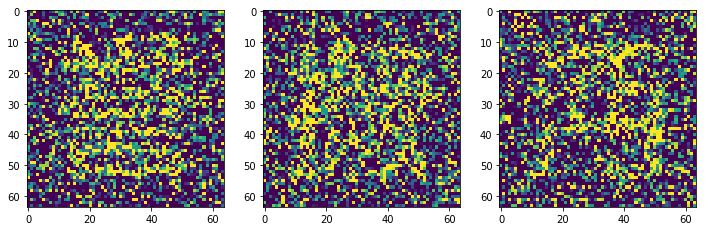

In [2]:
X = np.load('Denoising_data/Hanzi/tiles/training.npy')[:,3,...,None]
X_val = np.load('Denoising_data/Hanzi/tiles/validation.npy')[:,3,...,None]

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(X[0,...,0]);
plt.subplot(1,3,2)
plt.imshow(X[1,...,0]);
plt.subplot(1,3,3)
plt.imshow(X[2,...,0]);

In [3]:
X = np.array([(x - x.mean())/x.std() for x in X]).astype('float32')
X_val = np.array([(x - x.mean())/x.std() for x in X_val]).astype('float32')

#### Build denoising model and start training.

In [4]:
model = Noise2Same('trained_models/', 'denoising_Hanzi', dim=2, in_channels=1)

In [5]:
model.train(X, patch_size=[64, 64], validation=X_val, batch_size=64, steps=50000)

### Testing/Evaluation

#### Load testing image and do evaluation.

In [6]:
test = np.load('Denoising_data/Hanzi/tiles/testing.npy')[:,3]
test_gt = np.load('Denoising_data/Hanzi/tiles/testing.npy')[:,0]

In [7]:
def PSNR(gt, img):
    mse = np.mean(np.square(gt - img))
    return 20 * np.log10(255) - 10 * np.log10(mse)

def norm(x):
    x = (x-x.min())/(x.max()-x.min())
    return x

Using batch prediction.

In [8]:
preds = model.batch_predict(test.astype('float32'), batch_size=128)

In [9]:
psnrs = [PSNR(norm(preds[idx])*255, test_gt[idx]*255) for idx in range(len(test))]
print(np.array(psnrs).mean())

14.382866715089973


#### Visualizations

In the first row are the input noisy images, and in the second row are the denoised imags.

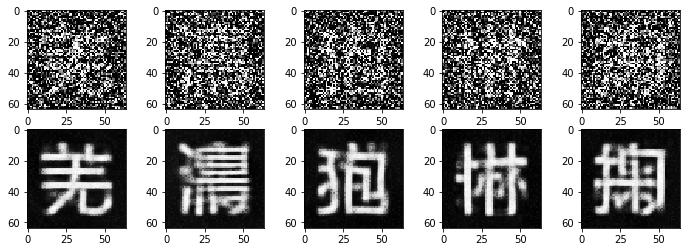

In [10]:
from utils.evaluation_utils import normalize

plt.figure(figsize=(12,4))
for i in range(5):
    idx = np.random.randint(len(test))
    plt.subplot(2,5,i+1)
    plt.imshow(test[idx], cmap='gray');
    plt.subplot(2,5,i+6)
    plt.imshow(normalize(preds[idx]), cmap='gray');